In [992]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier
from lifelines.utils import median_survival_times
from dtreeviz.trees import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import KFold
import joblib

In [2]:
brain_mets = pd.read_excel('./data/BrainMets_List_July2020_LF_OS.xlsx')
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)

### EDA

In [3]:
## Columns

In [4]:
len(brain_mets.columns)

57

In [5]:
## Rows

In [6]:
len(brain_mets)

10445

In [7]:
brain_mets['Sex'].value_counts()

F    6544
M    3837
0      64
Name: Sex, dtype: int64

In [8]:
brain_mets['Primary tumor Site'].value_counts()

Lung        3716
Breast      3030
Melanoma    2194
Kidney       521
GI           306
Other        241
GYN          194
Sarcoma      125
Unknown      102
Name: Primary tumor Site, dtype: int64

In [9]:
brain_mets.columns

Index(['PiCare MetID', 'Failure-binary', 'Failure-eventFreeTime',
       'Follow-up time', 'Time to death', 'Date GK', 'Age', 'Sex', 'Race',
       'Primary tumor Site', 'Primary tumor Histology', 'ECM', 'Location',
       'Brief location', 'Side', 'Lateral dimension', 'AP dimension',
       'Vertical dimension', '#Metastases at 1st GK',
       'Time between prim and met diagnosis', 'Prior SRS to same lesion',
       'Prior SRS to other lesion', 'KPS at 1st GK', 'GPA', 'RPA', 'ECOG',
       'Prescribed IDL', 'Target vol in IDL', 'IDL volume',
       'Vol in 12 Gy line', 'Vol in 10 Gy line', 'Conformity index',
       'Gradient index', 'Heterogeneity index', 'Prior_EBRT', 'Prior_RS',
       'Prior_Chemo', 'Conc_Chemo', 'Salvage_RS', 'Salv_surg', 'Headaches',
       'Seizures', 'Neuro symptoms', 'Prescription Dose', 'Max Dose',
       'Target volume', 'Target vol in IDL.1', 'Maximum Tumor Diameter',
       'Distance from Ventricle', 'BRAF_status', 'CKIT_status', 'NRAS_status',
       'EF

/Users/anishmukherjee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

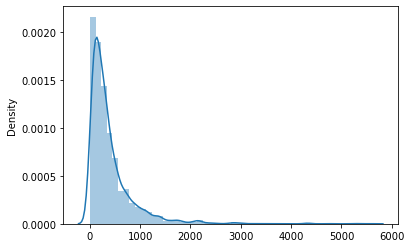

In [10]:
sns.distplot(x = brain_mets['Time to death'])


In [11]:
brain_mets['Follow-up time']

0          205
1          205
2          205
3           48
4           48
         ...  
10440   -42688
10441   -42688
10442   -42919
10443   -42921
10444   -42947
Name: Follow-up time, Length: 10445, dtype: int64

## Demographic Analysis

### Removing duplicates

In [13]:
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)

In [14]:
pats = brain_mets[['Patients']].drop_duplicates()

In [15]:
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)
brain_m = brain_mets[['Age','Sex','Patients','Primary tumor Site',
                      'Time to death','KPS at 1st GK','#Metastases at 1st GK','ECM']]
brain_m = brain_m.drop_duplicates()

In [16]:
brain_m.groupby(by = ['Patients']).count()['Age'].value_counts() 

1    1449
2     272
3      91
4      35
5      12
7       3
6       2
8       2
Name: Age, dtype: int64

In [17]:
brain_m.groupby(by = ['Patients']).count()['Primary tumor Site'].value_counts() 

1    1450
2     270
3      93
4      34
5      11
7       3
6       2
8       2
0       1
Name: Primary tumor Site, dtype: int64

In [18]:
brain_m.groupby(by = ['Patients']).count()['KPS at 1st GK'].value_counts() 

1    1387
2     260
3      88
0      78
4      34
5      12
7       3
6       2
8       2
Name: KPS at 1st GK, dtype: int64

In [19]:
brain_m.groupby(by = ['Patients']).count()['ECM'].value_counts() 

1    1449
2     272
3      91
4      35
5      12
7       3
6       2
8       2
Name: ECM, dtype: int64

In [20]:
## Identifying records that have duplicates in age

In [21]:
brain_mets

PiCare MetID  Failure-binary  Failure-eventFreeTime  \
0      BrainMets-UCSF-00001-001               0                  205.0   
1      BrainMets-UCSF-00001-002               1                  165.0   
2      BrainMets-UCSF-00001-003               0                  205.0   
3      BrainMets-UCSF-00002-001               0                   48.0   
4      BrainMets-UCSF-00002-002               0                   48.0   
...                         ...             ...                    ...   
10440  BrainMets-UCSF-01875-003               0                    NaN   
10441  BrainMets-UCSF-01875-004               0                    NaN   
10442  BrainMets-UCSF-01909-001               0                    NaN   
10443  BrainMets-UCSF-01921-001               0                   42.0   
10444  BrainMets-UCSF-01923-001               0                    NaN   

       Follow-up time  Time to death    Date GK        Age Sex  Race  \
0                 205          205.0 1999-07-08  51.369863   F   NaN   
1                 205          205.0 1999-07-08  51.369863   F   NaN   
2                 205          205.0 1999-07-08  51.369863   F   NaN   
3                  48           48.0 2001-03-22  77.591781   F   NaN   
4                  48           48.0 2001-03-22  77.591781   F   NaN   
...               ...            ...        ...        ...  ..   ...   
10440          -42688            NaN 2016-11-14  59.852055   M   NaN   
10441          -42688            NaN 2016-11-14  59.852055   M   NaN   
10442          -42919            NaN 2017-07-03  78.271233   M   NaN   
10443          -42921           42.0 2017-07-05  69.150685   M   NaN   
10444          -42947            NaN 2017-07-31  77.405479   M   NaN   

      Primary tumor Site  ... Maximum Tumor Diameter Distance from Ventricle  \
0                   Lung  ...                    3.9                     NaN   
1                   Lung  ...                    2.6                     NaN   
2                   Lung  ...                    1.1                     NaN   
3                   Lung  ...                    0.9                     NaN   
4                   Lung  ...                    2.0                     NaN   
...                  ...  ...                    ...                     ...   
10440           Melanoma  ...                    2.5                     NaN   
10441           Melanoma  ...                    3.3                     NaN   
10442             Kidney  ...                    1.5                     NaN   
10443                 GI  ...                    3.0                     NaN   
10444               Lung  ...                    2.3                     NaN   

      BRAF_status CKIT_status NRAS_status  EFGR_status  ALK_status  \
0             NaN         NaN         NaN          NaN         NaN   
1             NaN         NaN         NaN          NaN         NaN   
2             NaN         NaN         NaN          NaN         NaN   
3             NaN         NaN         NaN          NaN         NaN   
4             NaN         NaN         NaN          NaN         NaN   
...           ...         ...         ...          ...         ...   
10440         NaN         NaN         NaN          NaN         NaN   
10441         NaN         NaN         NaN          NaN         NaN   
10442         NaN         NaN         NaN          NaN         NaN   
10443         NaN         NaN         NaN          NaN         NaN   
10444         NaN         NaN         NaN          NaN         NaN   

       HER2-amplified status  Distance_from_ventricle  Patients  
0                        NaN                      NaN     00001  
1                        NaN                      NaN     00001  
2                        NaN                      NaN     00001  
3                        NaN                      NaN     00002  
4                        NaN                      NaN     00002  
...                      ...                      ...       ...  
1

In [22]:
dedup = brain_m.groupby(by = ['Patients']).count().reset_index()
dedup_age = dedup[dedup['Age']>1]
dedup_age

Patients  Age  Sex  Primary tumor Site  Time to death  KPS at 1st GK  \
7       00009    2    2                   2              2              2   
15      00017    2    2                   2              2              2   
18      00020    2    2                   2              2              2   
33      00035    3    3                   3              3              3   
34      00036    2    2                   2              2              2   
...       ...  ...  ...                 ...            ...            ...   
1837    01841    3    3                   3              0              0   
1840    01844    2    2                   2              0              2   
1842    01846    2    2                   2              0              2   
1848    01853    3    3                   3              3              3   
1853    01858    2    2                   2              0              2   

      #Metastases at 1st GK  ECM  
7                         2    2  
15                        2    2  
18                        2    2  
33                        3    3  
34                        2    2  
...                     ...  ...  
1837                      3    3  
1840                      2    2  
1842                      2    2  
1848                      3    3  
1853                      2    2  

[417 rows x 8 columns]

In [23]:
brain_mets[brain_mets['Patients'] == '00009']

PiCare MetID  Failure-binary  Failure-eventFreeTime  \
23  BrainMets-UCSF-00009-001               1                  143.0   
24  BrainMets-UCSF-00009-002               0                  170.0   
25  BrainMets-UCSF-00009-003               1                  143.0   
26  BrainMets-UCSF-00009-004               1                  143.0   
27  BrainMets-UCSF-00009-005               0                  170.0   
28  BrainMets-UCSF-00009-006               1                  143.0   
29  BrainMets-UCSF-00009-007               0                  104.0   
30  BrainMets-UCSF-00009-008               0                  104.0   

    Follow-up time  Time to death    Date GK        Age Sex  Race  \
23             170          170.0 1996-09-16  48.583562   M   NaN   
24             170          170.0 1996-09-16  48.583562   M   NaN   
25             170          170.0 1996-09-16  48.583562   M   NaN   
26             170          170.0 1996-09-16  48.583562   M   NaN   
27             170          170.0 1996-09-16  48.583562   M   NaN   
28             170          170.0 1996-09-16  48.583562   M   NaN   
29             104          104.0 1996-11-21  48.764384   M   NaN   
30             104          104.0 1996-11-21  48.764384   M   NaN   

   Primary tumor Site  ... Maximum Tumor Diameter Distance from Ventricle  \
23           Melanoma  ...                    2.1                     NaN   
24           Melanoma  ...                    1.4                     NaN   
25           Melanoma  ...                    0.9                     NaN   
26           Melanoma  ...                    0.9                     NaN   
27           Melanoma  ...                    1.5                     NaN   
28           Melanoma  ...                    1.5                     NaN   
29           Melanoma  ...                    1.2                     NaN   
30           Melanoma  ...                    1.0                     NaN   

   BRAF_status CKIT_status NRAS_status  EFGR_status  ALK_status  \
23         NaN         NaN         NaN          NaN         NaN   
24         NaN         NaN         NaN          NaN         NaN   
25         NaN         NaN         NaN          NaN         NaN   
26         NaN         NaN         NaN          NaN         NaN   
27         NaN         NaN         NaN          NaN         NaN   
28         NaN         NaN         NaN          NaN         NaN   
29         NaN         NaN         NaN          NaN         NaN   
30         NaN         NaN         NaN          NaN         NaN   

    HER2-amplified status  Distance_from_ventricle  Patients  
23                    NaN                      NaN     00009  
24                    NaN                      NaN     00009  
25                    NaN                      NaN     00009  
26                    NaN                      NaN     00009  
27                    NaN                      NaN     00009  
28                    NaN                      NaN     00009  
29                    NaN                      NaN     00009  
30                    NaN                      NaN     00009  

[8 rows x 57 columns]

In [24]:
dedup_tumor_site = brain_mets[['Patients','Primary tumor Site']].drop_duplicates()

In [25]:
dedup_tumor_site

Patients Primary tumor Site
0        00001               Lung
3        00002               Lung
8        00003           Melanoma
12       00004           Melanoma
14       00005               Lung
...        ...                ...
10437    01874               Lung
10438    01875           Melanoma
10442    01909             Kidney
10443    01921                 GI
10444    01923               Lung

[1871 rows x 2 columns]

In [26]:
dedup_tumor_site['Patients'].value_counts()

01478    2
01460    2
00734    2
01383    2
00275    2
        ..
00187    1
00434    1
00791    1
01775    1
01321    1
Name: Patients, Length: 1866, dtype: int64

In [27]:
# Patients with duplicate Tumor site 01383, 00275, 01460

In [28]:
pat_00275 = dedup_tumor_site[dedup_tumor_site['Patients'] == '00275']
pat_00275

Patients Primary tumor Site
1073    00275             Kidney
1079    00275                NaN

In [29]:
pat_00275

Patients Primary tumor Site
1073    00275             Kidney
1079    00275                NaN

In [30]:
### Patients with duplicate ECM 

In [30]:
dedup_ecm = brain_mets[['Patients','ECM']].drop_duplicates()
dedup_ecm['Patients'].value_counts()


01059    1
00572    1
00255    1
01792    1
01608    1
        ..
01285    1
00382    1
01018    1
00996    1
01254    1
Name: Patients, Length: 1866, dtype: int64

#### No duplicates for ECM

In [31]:
dedup_kps = brain_mets[['Patients','KPS at 1st GK']].drop_duplicates()
dedup_kps['Patients'].value_counts()

00105    1
01813    1
01811    1
01161    1
00643    1
        ..
00791    1
01775    1
01719    1
00802    1
01321    1
Name: Patients, Length: 1866, dtype: int64

In [34]:
### No duplicates for KPS as well

### Summary: Some patients have duplicate age columns and primary soc as na, do we exculde those patients ?

### Solution sort data by patient and date at 1st GK, that should be our unique list of pats 

In [32]:
brain_mets['Patients'] = brain_mets['PiCare MetID'].str.slice(15,20)
brain_m = brain_mets[['Age','Sex','Patients','Primary tumor Site',
                      'Time to death','KPS at 1st GK','#Metastases at 1st GK','ECM','Date GK','Follow-up time']]
brain_m = brain_m.drop_duplicates()

In [33]:
brain_mets

PiCare MetID  Failure-binary  Failure-eventFreeTime  \
0      BrainMets-UCSF-00001-001               0                  205.0   
1      BrainMets-UCSF-00001-002               1                  165.0   
2      BrainMets-UCSF-00001-003               0                  205.0   
3      BrainMets-UCSF-00002-001               0                   48.0   
4      BrainMets-UCSF-00002-002               0                   48.0   
...                         ...             ...                    ...   
10440  BrainMets-UCSF-01875-003               0                    NaN   
10441  BrainMets-UCSF-01875-004               0                    NaN   
10442  BrainMets-UCSF-01909-001               0                    NaN   
10443  BrainMets-UCSF-01921-001               0                   42.0   
10444  BrainMets-UCSF-01923-001               0                    NaN   

       Follow-up time  Time to death    Date GK        Age Sex  Race  \
0                 205          205.0 1999-07-08  51.369863   F   NaN   
1                 205          205.0 1999-07-08  51.369863   F   NaN   
2                 205          205.0 1999-07-08  51.369863   F   NaN   
3                  48           48.0 2001-03-22  77.591781   F   NaN   
4                  48           48.0 2001-03-22  77.591781   F   NaN   
...               ...            ...        ...        ...  ..   ...   
10440          -42688            NaN 2016-11-14  59.852055   M   NaN   
10441          -42688            NaN 2016-11-14  59.852055   M   NaN   
10442          -42919            NaN 2017-07-03  78.271233   M   NaN   
10443          -42921           42.0 2017-07-05  69.150685   M   NaN   
10444          -42947            NaN 2017-07-31  77.405479   M   NaN   

      Primary tumor Site  ... Maximum Tumor Diameter Distance from Ventricle  \
0                   Lung  ...                    3.9                     NaN   
1                   Lung  ...                    2.6                     NaN   
2                   Lung  ...                    1.1                     NaN   
3                   Lung  ...                    0.9                     NaN   
4                   Lung  ...                    2.0                     NaN   
...                  ...  ...                    ...                     ...   
10440           Melanoma  ...                    2.5                     NaN   
10441           Melanoma  ...                    3.3                     NaN   
10442             Kidney  ...                    1.5                     NaN   
10443                 GI  ...                    3.0                     NaN   
10444               Lung  ...                    2.3                     NaN   

      BRAF_status CKIT_status NRAS_status  EFGR_status  ALK_status  \
0             NaN         NaN         NaN          NaN         NaN   
1             NaN         NaN         NaN          NaN         NaN   
2             NaN         NaN         NaN          NaN         NaN   
3             NaN         NaN         NaN          NaN         NaN   
4             NaN         NaN         NaN          NaN         NaN   
...           ...         ...         ...          ...         ...   
10440         NaN         NaN         NaN          NaN         NaN   
10441         NaN         NaN         NaN          NaN         NaN   
10442         NaN         NaN         NaN          NaN         NaN   
10443         NaN         NaN         NaN          NaN         NaN   
10444         NaN         NaN         NaN          NaN         NaN   

       HER2-amplified status  Distance_from_ventricle  Patients  
0                        NaN                      NaN     00001  
1                        NaN                      NaN     00001  
2                        NaN                      NaN     00001  
3                        NaN                      NaN     00002  
4                        NaN                      NaN     00002  
...                      ...                      ...       ...  
1

In [34]:
brain_mets['Follow-up time'].isna().sum()

0

In [35]:
analysis = brain_mets[(brain_mets['Time to death'].notnull()) & (brain_mets['Follow-up time'] > 0)]

In [36]:
analysis = analysis[['Patients','Follow-up time','Time to death']].drop_duplicates()
analysis['diff'] = analysis['Follow-up time'] - analysis['Time to death'] 

### Difference between follow up time and time to death

(array([   2.,    0.,    0.,    0.,    2.,    2.,    4.,   10.,   26.,
        1445.]),
 array([-4863. , -4376.7, -3890.4, -3404.1, -2917.8, -2431.5, -1945.2,
        -1458.9,  -972.6,  -486.3,     0. ]),
 <BarContainer object of 10 artists>)

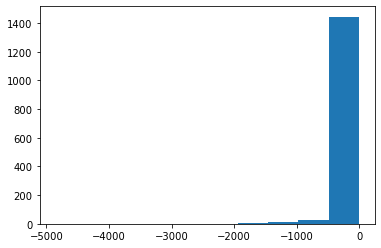

In [37]:
plt.hist(analysis['diff'])

### Taking the first treatment date

In [38]:
brain_m['row_num'] = brain_m.sort_values(['Patients','Date GK'], \
             ascending=[True,True])\
             .groupby(['Patients'])\
             .cumcount() + 1
final_dataset = brain_m[brain_m['row_num'] == 1]

In [39]:
### Excluding null values

In [40]:
final_dataset

Age Sex Patients Primary tumor Site  Time to death  \
0      51.369863   F    00001               Lung          205.0   
3      77.591781   F    00002               Lung           48.0   
8      45.400000   M    00003           Melanoma          189.0   
12     51.564384   F    00004           Melanoma          127.0   
14     39.726027   M    00005               Lung            NaN   
...          ...  ..      ...                ...            ...   
10437  85.098630   F    01874               Lung            NaN   
10438  59.852055   M    01875           Melanoma            NaN   
10442  78.271233   M    01909             Kidney            NaN   
10443  69.150685   M    01921                 GI           42.0   
10444  77.405479   M    01923               Lung            NaN   

       KPS at 1st GK  #Metastases at 1st GK    ECM    Date GK  Follow-up time  \
0               80.0                    3.0  False 1999-07-08             205   
3               60.0                    5.0  False 2001-03-22              48   
8               90.0                    4.0   True 1994-07-12             189   
12              70.0                    2.0   True 1997-06-30             127   
14              90.0                    6.0   True 1999-06-03              19   
...              ...                    ...    ...        ...             ...   
10437            NaN                    1.0      0 2016-10-20          -42663   
10438           90.0                    4.0   True 2016-11-14          -42688   
10442           70.0                    1.0      0 2017-07-03          -42919   
10443            NaN                    1.0      0 2017-07-05          -42921   
10444            NaN                    1.0      0 2017-07-31          -42947   

       row_num  
0            1  
3            1  
8            1  
12           1  
14           1  
...        ...  
10437        1  
10438        1  
10442        1  
10443        1  
10444        1  

[1866 rows x 11 columns]

In [41]:
final_dataset['Time to death'] = np.where((final_dataset['Time to death'].isna()) & (
                                            final_dataset['Follow-up time'] > 0),
                                          final_dataset['Follow-up time'],
                                          final_dataset['Time to death'])

<ipython-input-41-78dcad5e5442>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Time to death'] = np.where((final_dataset['Time to death'].isna()) & (


In [42]:
final_dataset.isna().sum()

Age                        0
Sex                        0
Patients                   0
Primary tumor Site         1
Time to death            287
KPS at 1st GK             78
#Metastases at 1st GK      3
ECM                        0
Date GK                    0
Follow-up time             0
row_num                    0
dtype: int64

#### filtering out null values 

In [43]:
final_dataset = final_dataset[(final_dataset['Time to death'].notnull()) & (final_dataset['KPS at 1st GK'].notnull())
                             &(final_dataset['#Metastases at 1st GK'].notnull())]

In [44]:
final_dataset

Age Sex Patients Primary tumor Site  Time to death  \
0      51.369863   F    00001               Lung          205.0   
3      77.591781   F    00002               Lung           48.0   
8      45.400000   M    00003           Melanoma          189.0   
12     51.564384   F    00004           Melanoma          127.0   
14     39.726027   M    00005               Lung           19.0   
...          ...  ..      ...                ...            ...   
10304  57.676712   F    01839               Lung           16.0   
10378  62.284932   F    01853                GYN          276.0   
10396  62.120548   M    01855               Lung          123.0   
10425  33.701370   F    01863             Breast          185.0   
10435  55.852055   M    01873           Melanoma           11.0   

       KPS at 1st GK  #Metastases at 1st GK    ECM    Date GK  Follow-up time  \
0               80.0                    3.0  False 1999-07-08             205   
3               60.0                    5.0  False 2001-03-22              48   
8               90.0                    4.0   True 1994-07-12             189   
12              70.0                    2.0   True 1997-06-30             127   
14              90.0                    6.0   True 1999-06-03              19   
...              ...                    ...    ...        ...             ...   
10304           80.0                   24.0   True 2016-10-19          -42662   
10378           90.0                    9.0      0 2016-11-28          -42702   
10396           80.0                    3.0      0 2016-12-01          -42705   
10425           90.0                    1.0      0 2016-12-28          -42732   
10435           40.0                    2.0   True 2016-05-19          -42509   

       row_num  
0            1  
3            1  
8            1  
12           1  
14           1  
...        ...  
10304        1  
10378        1  
10396        1  
10425        1  
10435        1  

[1532 rows x 11 columns]

In [45]:
final_dataset.describe()

Age  Time to death  KPS at 1st GK  #Metastases at 1st GK  \
count  1532.000000    1532.000000    1532.000000            1532.000000   
mean     57.576546     564.060052      81.344648               3.869452   
std      12.494814     812.813094      10.783482               4.109848   
min       7.000000       1.000000      40.000000               1.000000   
25%      49.412329     139.750000      80.000000               1.000000   
50%      58.053425     290.000000      80.000000               3.000000   
75%      66.206849     612.250000      90.000000               5.000000   
max      97.810959    6517.000000     100.000000              61.000000   

       Follow-up time  row_num  
count     1532.000000   1532.0  
mean     -6493.454961      1.0  
std      15348.323162      0.0  
min     -42732.000000      1.0  
25%         25.000000      1.0  
50%        181.000000      1.0  
75%        478.500000      1.0  
max       6517.000000      1.0

#### Number of patients left is 1402
#### There are patients with 61 mets !

## DS GPA SCORE 

In [46]:
### Age

/Users/anishmukherjee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


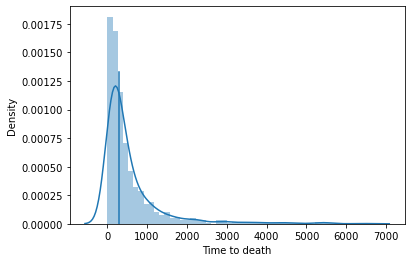

In [47]:
ttd = final_dataset[final_dataset['Time to death'].isna() == False]['Time to death'] 
sns.distplot(ttd)
plt.axvline(np.median(ttd),0,0.7)

In [48]:
## The distribution is right skewed with medain = 275 days

In [49]:
def GPA(df):
    ### LUNG GPA
    df_lung = df[df['Primary tumor Site'] == 'Lung'].copy()
    
    df_lung['Age_GPA'] = np.where(df_lung['Age']>60,0,np.where(df_lung['Age']<50,1,0.5))
    
    df_lung['KPS_GPA'] = np.where(df_lung['KPS at 1st GK'] < 70,0,
                                        np.where(df_lung['KPS at 1st GK']>=90,1,0.5))
    
    df_lung['ECM_GPA'] = np.where(((df_lung['ECM']=='False' ) | (df_lung['ECM']==0)),1,
                                    np.where(df_lung['ECM']=='Unkn',0.5,0))

    df_lung['BM_GPA'] = np.where(df_lung['#Metastases at 1st GK'] >3 ,0,
                                 np.where(df_lung['#Metastases at 1st GK']<=1,1,0.5))

    df_lung['patient_gpa'] = df_lung['Age_GPA'] + df_lung['KPS_GPA'] + df_lung['ECM_GPA'] + df_lung['BM_GPA']

    df_lung.drop(['Age_GPA','KPS_GPA','ECM_GPA','BM_GPA'],inplace = True, axis = 1)
    
    ### Melanoma GPA
    
    df_melanoma = df[df['Primary tumor Site'] == 'Melanoma'].copy()
    
    df_melanoma['KPS_GPA'] = np.where(df_melanoma['KPS at 1st GK'] < 70,0,
                                      np.where(df_melanoma['KPS at 1st GK']>=90,2,1))
    
    df_melanoma['BM_GPA'] = np.where(df_melanoma['#Metastases at 1st GK'] >3 ,0,
                                     np.where(df_melanoma['#Metastases at 1st GK']<=1,2,1))
    
    df_melanoma['patient_gpa'] = df_melanoma['KPS_GPA'] + df_melanoma['BM_GPA']  
                                    
    
    df_melanoma.drop(['KPS_GPA','BM_GPA'],inplace = True, axis = 1)
        
    
    ### Breast GPA
    
    df_breast = df[df['Primary tumor Site'] == 'Breast'].copy()
    
    
    df_breast['KPS_GPA'] = np.where(df_breast['KPS at 1st GK'] < 70, 0,
                                      np.where(df_breast['KPS at 1st GK'] >= 90, 1, 0.5))
    
    
    df_breast['Age_GPA'] = np.where(df_breast['Age'] > 60,0,np.where(df_breast['Age'] < 50, 1, 0.5))
    
    
    df_breast['BM_GPA'] = np.where(df_breast['#Metastases at 1st GK'] >3, 0,
                               np.where(df_breast['#Metastases at 1st GK']<=1, 1, 0.5))
    
    
    df_breast['ECM_GPA'] = np.where(((df_breast['ECM']=='False' ) | (df_breast['ECM']==0)), 1,
                                    np.where(df_breast['ECM']=='Unkn', 0.5, 0))
    
    
    df_breast['patient_gpa'] = df_breast['Age_GPA'] + df_breast['KPS_GPA'] + \
                               df_breast['ECM_GPA'] + df_breast['BM_GPA']
    
    
    df_breast.drop(['KPS_GPA','BM_GPA','Age_GPA','ECM_GPA'],inplace = True, axis = 1)
    
    ### Kidney GPA
    
    df_kidney = df[df['Primary tumor Site'] == 'Kidney'].copy()
    
    df_kidney['KPS_GPA'] = np.where(df_kidney['KPS at 1st GK'] < 70,0,
                                    np.where(df_kidney['KPS at 1st GK']>=90, 2, 1))
    
    df_kidney['BM_GPA'] = np.where(df_kidney['#Metastases at 1st GK'] > 3 ,0,
                                    np.where(df_kidney['#Metastases at 1st GK']<=1, 2, 1))
    
    df_kidney['patient_gpa'] = df_kidney['KPS_GPA'] + df_kidney['BM_GPA']  
    
    
    df_kidney.drop(['KPS_GPA','BM_GPA'],inplace = True, axis = 1)
    
    
    ### GI GPA
    
    df_gi = df[df['Primary tumor Site'] == 'GI'].copy()
    
    df_gi['patient_gpa'] = np.where(df_gi['KPS at 1st GK'] < 70,0,
                                    np.where(df_gi['KPS at 1st GK']== 70, 1,
                                    np.where(df_gi['KPS at 1st GK']== 80, 2,
                                    np.where(df_gi['KPS at 1st GK']== 90, 3, 4))))
    
    ### Other_cancers
    
    df_other = df[~df['Primary tumor Site'].isin(['GI','Kidney','Breast','Melanoma','Lung'])]
    
    df_other['patient_gpa'] = None
    
    df = pd.concat([df_melanoma,df_lung,df_gi,df_kidney,df_breast,df_other])
    
    return df

## Random

In [63]:
final_dataset['Primary tumor Site'].value_counts()

Lung        559
Breast      362
Melanoma    340
Kidney       95
GI           51
Other        48
GYN          39
Sarcoma      22
Unknown      16
Name: Primary tumor Site, dtype: int64

In [64]:
559 + 362 + 340 + 95 + 51

1407

In [65]:
final_dataset_gpa = GPA(final_dataset)

<ipython-input-49-4e7cd007bb25>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_other['patient_gpa'] = None


In [66]:
final_dataset_gpa['Primary tumor Site'].value_counts().sum()

1532

In [67]:
final_dataset_gpa.isna().sum()

Age                        0
Sex                        0
Patients                   0
Primary tumor Site         0
Time to death              0
KPS at 1st GK              0
#Metastases at 1st GK      0
ECM                        0
Date GK                    0
Follow-up time             0
row_num                    0
patient_gpa              125
dtype: int64

In [68]:
final_dataset_gpa['patient_gpa'].value_counts()

2.0    368
3.0    263
1.0    226
1.5    179
2.5    158
4.0     88
0.5     68
3.5     31
0.0     26
Name: patient_gpa, dtype: int64

## Time to death

In [69]:
## Only considering patients that died
final_dataset_gpa[(final_dataset_gpa['Primary tumor Site'] == 'GI') & (final_dataset_gpa['patient_gpa'] == 4)]

Age Sex Patients Primary tumor Site  Time to death  KPS at 1st GK  \
1082  76.575342   M    00277                 GI          356.0          100.0   

      #Metastases at 1st GK   ECM    Date GK  Follow-up time  row_num  \
1082                    1.0  True 1997-12-05             356        1   

     patient_gpa  
1082           4

In [70]:
final_dataset_gpa['gpa_range'] = np.where(final_dataset_gpa['patient_gpa'] == None, None,
                                          np.where(final_dataset_gpa['patient_gpa'] <=1, '0-1', 
                                          np.where((final_dataset_gpa['patient_gpa'] >1) & 
                                          (final_dataset_gpa['patient_gpa'] <=2),'1.5-2',
                                          np.where(final_dataset_gpa['patient_gpa'] > 3,'3.5-4','2.5-3.0'))))         

In [71]:
n_sizes = final_dataset_gpa.groupby(by = ['Primary tumor Site','gpa_range']).count().reset_index()
n_sizes = n_sizes[['Primary tumor Site','gpa_range','patient_gpa']]
n_sizes.rename(columns = {'patient_gpa' : 'patient_count'}, inplace = True)

### CI Table

In [73]:
final_dataset_gpa['Died'] = np.where(final_dataset_gpa['Time to death']== None, 0, 1)
final_dataset_gpa['Died'] = final_dataset_gpa['Died'].astype(bool)
median_intmed = final_dataset_gpa[['Died','Primary tumor Site','gpa_range','Time to death']]
median_intmed = median_intmed[median_intmed['Primary tumor Site'].isin(['Breast','GI','Kidney','Lung','Melanoma'])]
median_intmed['months'] = median_intmed['Time to death']/30.5

In [74]:
def CI(df):
    total_df = pd.DataFrame()
    for j in df['Primary tumor Site'].unique():
        for i in df[df['Primary tumor Site'] == j]['gpa_range'].unique():
            df_temp = df[(df['gpa_range'] == i) &(df['Primary tumor Site'] == j)]
            kmf = KaplanMeierFitter()
            T = df_temp['months']
            E = df_temp['Died'].astype(bool)
            kmf.fit(T,E)
            median_ci = median_survival_times(kmf.confidence_interval_)
            median_ci['median'] = median_survival_times(kmf)
            median_ci['gpa_range'] = i
            median_ci['Primary tumor Site'] = j
            total_df = pd.concat([total_df,median_ci],axis = 0)
    total_df.rename(columns = {'KM_estimate_lower_0.95':'median_lower_lim','KM_estimate_upper_0.95':'median_upper_lim'},
                        inplace = True)        
    total_df = total_df[['Primary tumor Site','gpa_range','median','median_lower_lim','median_upper_lim']]
    total_df.sort_values(by = ['Primary tumor Site','gpa_range'], inplace = True)
    return total_df

In [75]:
median_table = CI(median_intmed)
median_table = median_table.merge(n_sizes, on = ['Primary tumor Site','gpa_range'], how = 'left')

In [76]:
median_table

Primary tumor Site gpa_range     median  median_lower_lim  \
0              Breast       0-1   9.016393          5.901639   
1              Breast     1.5-2  11.868852         10.196721   
2              Breast   2.5-3.0  13.475410         11.672131   
3              Breast     3.5-4  29.704918         11.540984   
4                  GI       0-1   5.573770          2.229508   
5                  GI     1.5-2  10.819672          5.245902   
6                  GI   2.5-3.0   7.639344          5.147541   
7                  GI     3.5-4  11.672131         11.672131   
8              Kidney       0-1   5.704918          4.983607   
9              Kidney     1.5-2   3.803279          2.196721   
10             Kidney   2.5-3.0  14.754098          7.344262   
11             Kidney     3.5-4  24.032787          6.491803   
12               Lung       0-1   8.000000          6.360656   
13               Lung     1.5-2   9.180328          8.295082   
14               Lung   2.5-3.0  14.491803         11.934426   
15               Lung     3.5-4  20.459016          9.672131   
16           Melanoma       0-1   3.114754          2.459016   
17           Melanoma     1.5-2   6.754098          5.180328   
18           Melanoma   2.5-3.0   8.557377          6.327869   
19           Melanoma     3.5-4  13.409836          8.819672   

    median_upper_lim  patient_count  
0          12.131148             87  
1          13.409836            169  
2          20.557377             88  
3          51.409836             18  
4          10.262295             14  
5          14.590164             17  
6          11.016393             19  
7          11.672131              1  
8           9.213115             25  
9          15.672131             22  
10         17.213115             35  
11         36.196721             13  
12          9.573770            132  
13         10.688525            218  
14         17.278689            182  
15         32.557377             27  
16          4.918033             62  
17          7.639344            121  
18         10.655738             97  
19         17.311475             60

In [77]:
sum(median_table['patient_count'])

1407

### KP Meier curves

In [89]:
final_dataset_gpa['Died'] = np.where(final_dataset_gpa['Time to death']== None, 0, 1)
final_dataset_gpa['Died'] = final_dataset_gpa['Died'].astype(bool)
kms = final_dataset_gpa[['Died','Primary tumor Site','gpa_range','Time to death']]
kms['months'] = kms['Time to death']/30.5
kms.sort_values(by =['Time to death'], ascending = True, inplace = True)

<ipython-input-89-1b5d23a38e44>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kms['months'] = kms['Time to death']/30.5
<ipython-input-89-1b5d23a38e44>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kms.sort_values(by =['Time to death'], ascending = True, inplace = True)


In [90]:
breast = kms[(kms['Primary tumor Site'] == 'Breast')][['months','Died','gpa_range']]
kidney = kms[(kms['Primary tumor Site'] == 'Kidney')][['months','Died','gpa_range']]
lung = kms[(kms['Primary tumor Site'] == 'Lung')][['months','Died','gpa_range']]
Melanoma = kms[(kms['Primary tumor Site'] == 'Melanoma')][['months','Died','gpa_range']]
GI = kms[(kms['Primary tumor Site'] == 'GI')][['months','Died','gpa_range']]

In [91]:
def survival_curve_kmf(data,cluster_list,site_name = None ,classes = "gpa_range", survival_col = "Died",time_col = "months"):
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    ci_lst = [] #(site_name, gpa_range, median, lower_ci, higher_ci)
    for c in cluster_list:
        mask = data[classes] == c
        if len(data[survival_col][mask]) ==0:
            continue
        kmf.fit(data[time_col][mask],event_observed=data[survival_col][mask],label = f"GPA_range = {c}")
        kmf.plot_survival_function(ax=ax)
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.title('Survival Curve for %s' % site_name)
    plt.show()

In [92]:
gpa_range = Melanoma['gpa_range'].value_counts().index.values

In [93]:
gpa_range.sort()

### Breast survival curve

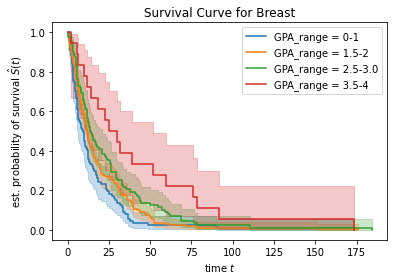

In [94]:
survival_curve_kmf(breast, gpa_range, site_name = 'Breast')

### Kidney survival curve

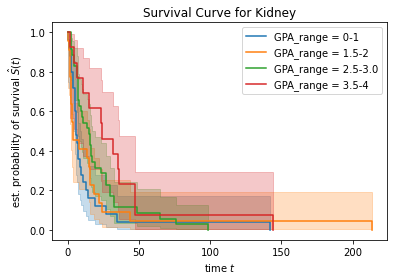

In [95]:
survival_curve_kmf(kidney, gpa_range, site_name = 'Kidney')

### Lung survival curve

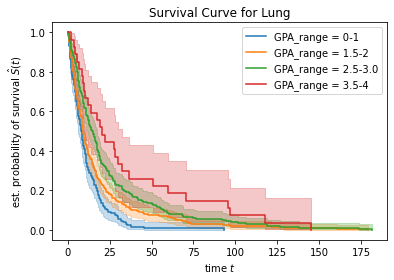

In [96]:
survival_curve_kmf(lung, gpa_range, site_name = 'Lung')

### Melanoma survival curve

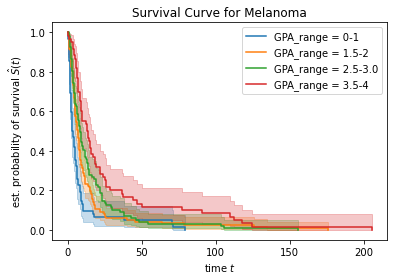

In [97]:
survival_curve_kmf(Melanoma, gpa_range, site_name = 'Melanoma')

In [98]:
### GI survival curve

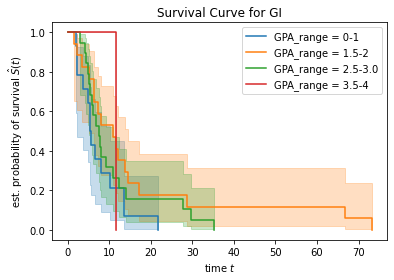

In [99]:
survival_curve_kmf(GI, gpa_range, site_name = 'GI')

# STEP 2

### Modelling part

#### Feature engineering

In [100]:
#### brain_mets is the original raw data 

In [179]:
def label_encoding_with_NAs(train, col):
    c = train[col].astype('category')
    d = dict(enumerate(c.cat.categories))
    new_d = {}
    for i in d:
        new_d[i+1] = d[i]
    train[col] = train[col].astype('category').cat.as_ordered()
    encoder = train[col].cat.categories
    # leaving 0 for NAs
    train[col] = train[col].cat.codes + 1
    return new_d    
    #val[col] = pd.Categorical(val[col], categories=encoder, ordered=True)
    #val[col] = val[col].cat.codes + 1


In [180]:
def reverse_label_encoding_with_NAs(train, col):
    c = train[col].astype('category')
    d = dict(enumerate(c.cat.categories))
    new_d = {}
    for i in d:
        new_d[i+1] = d[i]
    # leaving 0 for NAs
    print(new_d)
    

#### Selecting 1st row

In [969]:
brain_mets['row_num'] = brain_mets.sort_values(['Patients','Date GK'], \
             ascending=[True,True])\
             .groupby(['Patients'])\
             .cumcount() + 1
modelling_data = brain_mets[brain_mets['row_num'] == 1]

In [970]:
modelling_data.drop(['PiCare MetID', 'Failure-binary', 
                      'Failure-eventFreeTime', 'row_num',
                      'Primary tumor Histology', 'Date GK', 'Patients'
                     ,'Lateral dimension', 'AP dimension', 'Vertical dimension','GPA',
                      'RPA','ECOG','Prescribed IDL', 'Target vol in IDL', 'Target vol in IDL', 'IDL volume',
                     'Vol in 12 Gy line', 'Vol in 10 Gy line', 'Conformity index',
                     'Gradient index', 'Heterogeneity index', 'Salvage_RS', 
                      'Salv_surg', 'Headaches', 'Seizures', 'Prescription Dose', 
                      'Max Dose', 'Target vol in IDL', 'Distance from Ventricle',
                     'BRAF_status', 'CKIT_status', 'NRAS_status', 'EFGR_status',
                      'ALK_status', 'HER2-amplified status', 'Distance_from_ventricle',
                     'Target vol in IDL.1'
                     ], axis = 1, inplace = True)

/Users/anishmukherjee/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [971]:
percent_missing = modelling_data.isnull().sum()/len(modelling_data)
missing_value_df = pd.DataFrame({'column_name': modelling_data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending = False)

column_name  \
Race                                                                Race   
Conc_Chemo                                                    Conc_Chemo   
Brief location                                            Brief location   
Time to death                                              Time to death   
Neuro symptoms                                            Neuro symptoms   
Time between prim and met diagnosis  Time between prim and met diagnosis   
Prior_RS                                                        Prior_RS   
Prior_EBRT                                                    Prior_EBRT   
Maximum Tumor Diameter                            Maximum Tumor Diameter   
Target volume                                              Target volume   
KPS at 1st GK                                              KPS at 1st GK   
Side                                                                Side   
Location                                                        Location   
#Metastases at 1st GK                              #Metastases at 1st GK   
Primary tumor Site                                    Primary tumor Site   
Prior SRS to same lesion                        Prior SRS to same lesion   
Prior SRS to other lesion                      Prior SRS to other lesion   
ECM                                                                  ECM   
Prior_Chemo                                                  Prior_Chemo   
Sex                                                                  Sex   
Age                                                                  Age   
Follow-up time                                            Follow-up time   

                                     percent_missing  
Race                                        1.000000  
Conc_Chemo                                  0.840836  
Brief location                              0.793676  
Time to death                               0.224544  
Neuro symptoms                              0.163987  
Time between prim and met diagnosis         0.161308  
Prior_RS                                    0.086817  
Prior_EBRT                                  0.053055  
Maximum Tumor Diameter                      0.050375  
Target volume                               0.042337  
KPS at 1st GK                               0.041801  
Side                                        0.033762  
Location                                    0.030547  
#Metastases at 1st GK                       0.001608  
Primary tumor Site                          0.000536  
Prior SRS to same lesion                    0.000000  
Prior SRS to other lesion                   0.000000  
ECM                                         0.000000  
Prior_Chemo                                 0.000000  
Sex                                         0.000000  
Age                                         0.000000  
Follow-up time                              0.000000

In [972]:
col_list = missing_value_df[missing_value_df['percent_missing'] < 0.40]['column_name'].values

In [973]:
col_list

array(['Follow-up time', 'Time to death', 'Age', 'Sex',
       'Primary tumor Site', 'ECM', 'Location', 'Side',
       '#Metastases at 1st GK', 'Time between prim and met diagnosis',
       'Prior SRS to same lesion', 'Prior SRS to other lesion',
       'KPS at 1st GK', 'Prior_EBRT', 'Prior_RS', 'Prior_Chemo',
       'Neuro symptoms', 'Target volume', 'Maximum Tumor Diameter'],
      dtype=object)

In [974]:
modelling_data = modelling_data[col_list]

In [975]:
### Label encoding non numeric columnms such as Sex

In [976]:
label_enc = modelling_data.iloc[:100,].applymap(np.isreal).all(0).values == False

In [977]:
label_enc_cols = list(modelling_data.iloc[:100,].applymap(np.isreal).all(0)[label_enc].index)

In [978]:
reverse_encoding = {}
for i in label_enc_cols:
    if i != 'Primary tumor Site': 
        print(i)
        reverse_encoding[i] = label_encoding_with_NAs(modelling_data, i)

Sex
ECM
Location
Side
Prior_RS
Prior_Chemo
Neuro symptoms


In [979]:
reverse_encoding

{'Sex': {1: 0, 2: 'F', 3: 'M'},
 'ECM': {1: 0, 2: 'False', 3: 'True', 4: 'Unkn'},
 'Location': {1: 'Basal Ganglia',
  2: 'Basal_Ganglia',
  3: 'Brainstem_Medulla',
  4: 'Brainstem_Midbrain',
  5: 'Brainstem_Pons',
  6: 'Cavernous Sinus',
  7: 'Cavernous_Sinus',
  8: 'Cerebellopontine Angle',
  9: 'Cerebellopontine_Angle',
  10: 'Cerebellum',
  11: 'Corpus Callosum',
  12: 'Corpus_Callosum',
  13: 'Falx',
  14: 'Frontal Lobe',
  15: 'Frontal Lobe*',
  16: 'Frontal_Lobe',
  17: 'Frontal_Motor',
  18: 'Frontoparietal',
  19: 'Frontotemporal',
  20: 'Hypothalamus',
  21: 'Insula',
  22: 'Occipital Lobe',
  23: 'Occipital Lobe(medial)',
  24: 'Occipital Lobe*',
  25: 'Occipital_Lobe',
  26: 'Orbit',
  27: 'Parafalcine Region',
  28: 'Parietal Lobe',
  29: 'Parietal Lobe*',
  30: 'Parietal_Lobe',
  31: 'Parieto-Occipital',
  32: 'Parieto-occipital',
  33: 'Pineal Region',
  34: 'Pineal_Region',
  35: 'Sella',
  36: 'Temporal Lobe',
  37: 'Temporal Lobe(inf.post)',
  38: 'Temporal Lobe*',
  3

#### Preprocessing time of death

In [980]:
modelling_data['Time to death'] = np.where((modelling_data['Time to death'].isna()) & (
                                            modelling_data['Follow-up time'] > 0),
                                          modelling_data['Follow-up time'],
                                          modelling_data['Time to death'])
modelling_data.drop('Follow-up time' , axis = 1, inplace = True)
modelling_data['Time to death'] = modelling_data['Time to death']/30.5

In [981]:
### Dropping patient having null time of death

In [982]:
modelling_data = modelling_data[(modelling_data['Time to death'].notnull() & (modelling_data['KPS at 1st GK'].notnull())
                             &(modelling_data['#Metastases at 1st GK'].notnull()))] 

In [983]:
modelling_data

Time to death        Age  Sex Primary tumor Site  ECM  Location  Side  \
0           6.721311  51.369863    2               Lung    2        10     3   
3           1.573770  77.591781    2               Lung    2        44     0   
8           6.196721  45.400000    3           Melanoma    3        14     1   
12          4.163934  51.564384    2           Melanoma    3        28     1   
14          0.622951  39.726027    3               Lung    3        10     3   
...              ...        ...  ...                ...  ...       ...   ...   
10304       0.524590  57.676712    2               Lung    3         0     0   
10378       9.049180  62.284932    2                GYN    1         0     0   
10396       4.032787  62.120548    3               Lung    1         0     0   
10425       6.065574  33.701370    2             Breast    1        39     1   
10435       0.360656  55.852055    3           Melanoma    3        16     3   

       #Metastases at 1st GK  Time between prim and met diagnosis  \
0                        3.0                                  6.0   
3                        5.0                                896.0   
8                        4.0                                  4.0   
12                       2.0                               3265.0   
14                       6.0                                178.0   
...                      ...                                  ...   
10304                   24.0                                210.0   
10378                    9.0                               1262.0   
10396                    3.0                                425.0   
10425                    1.0                                  NaN   
10435                    2.0                                 29.0   

       Prior SRS to same lesion  Prior SRS to other lesion  KPS at 1st GK  \
0                             0                          0           80.0   
3                             0                          0           60.0   
8                             0                          0           90.0   
12                            0                          0           70.0   
14                            0                          0           90.0   
...                         ...                        ...            ...   
10304                         0                          0           80.0   
10378                         0                          0           90.0   
10396                         0                          0           80.0   
10425                         0                          0           90.0   
10435                         0                          0           40.0   

      Prior_EBRT  Prior_RS  Prior_Chemo  Neuro symptoms  Target volume  \
0           True         1            3               2         15.500   
3           True         1            3               2          0.230   
8           True         1            2               1          0.030   
12         False         1            3               1          1.600   
14          True         2            3               2          2.700   
...          ...       ...          ...             ...            ...   
10304      False         1            1               2            NaN   
10378      False         1            1               1            NaN   
10396       True         1            1               2            NaN   
10425        NaN         0            1               0          0.608   
10435       True         1            1               2          4.400   

       Maximum Tumor Diameter  
0                         3.9  
3                         0.9  
8                         0.3  
12                        1.8  
14                        2.2  
...                       ...  
10304                     NaN  
10378                     NaN  
10396                     NaN  
10425                     1.2  
10435                     2.4  

[1532 rows x 18 co

In [984]:
modelling_data.isnull().sum()

Time to death                            0
Age                                      0
Sex                                      0
Primary tumor Site                       0
ECM                                      0
Location                                 0
Side                                     0
#Metastases at 1st GK                    0
Time between prim and met diagnosis    223
Prior SRS to same lesion                 0
Prior SRS to other lesion                0
KPS at 1st GK                            0
Prior_EBRT                              30
Prior_RS                                 0
Prior_Chemo                              0
Neuro symptoms                           0
Target volume                           17
Maximum Tumor Diameter                  34
dtype: int64

#### filling null values by median

In [985]:
modelling_data.fillna(modelling_data.median(), inplace = True)

In [986]:
modelling_data.isnull().sum()

Time to death                          0
Age                                    0
Sex                                    0
Primary tumor Site                     0
ECM                                    0
Location                               0
Side                                   0
#Metastases at 1st GK                  0
Time between prim and met diagnosis    0
Prior SRS to same lesion               0
Prior SRS to other lesion              0
KPS at 1st GK                          0
Prior_EBRT                             0
Prior_RS                               0
Prior_Chemo                            0
Neuro symptoms                         0
Target volume                          0
Maximum Tumor Diameter                 0
dtype: int64

In [988]:
modelling_data['Primary tumor Site'].value_counts()

Lung        559
Breast      362
Melanoma    340
Kidney       95
GI           51
Other        48
GYN          39
Sarcoma      22
Unknown      16
Name: Primary tumor Site, dtype: int64

In [210]:
# brain_mets_feat['Neuro symptoms'] = np.where(brain_mets_feat['Neuro symptoms'].isna(), -1, 
#                            np.where(brain_mets_feat['Neuro symptoms'] == 'True',1,0))
# brain_mets_feat['Side'] = np.where(brain_mets_feat['Side'].isna(), -1, 
#                            np.where(brain_mets_feat['Side'] == 'Right', 1,
#                            np.where(brain_mets_feat['Side'] == 'Left', 2, 3)))
# brain_mets_feat['Seizures'] = np.where((brain_mets_feat['Seizures'].isna() |
#                                        brain_mets_feat['Seizures'] == 'Unkn'), -1, 
#                               np.where(brain_mets_feat['Seizures'] == 'False', 0, 1))
# brain_mets_feat['Lateral dimension'].fillna(brain_mets_feat['Lateral dimension'].mean(), inplace = True)
# brain_mets_feat['AP dimension'].fillna(brain_mets_feat['AP dimension'].mean(), inplace = True)
# brain_mets_feat['Vertical dimension'].fillna(brain_mets_feat['Vertical dimension'].mean(), inplace = True)
# max_dia = brain_mets_feat[['Maximum Tumor Diameter','Patients']].groupby(by = 'Patients').max().reset_index()
# target_volume = brain_mets_feat[['Patients','Target volume']].groupby(by = 'Patients').sum().reset_index()
# ebrt = brain_mets_feat[['Patients','Prior_EBRT']].drop_duplicates()
# prior_rs = brain_mets_feat[['Patients','Prior_RS']].drop_duplicates()
# rest_ = brain_mets_feat[['Patients','Lateral dimension', 'Vertical dimension', 'AP dimension'
#                         ,'Seizures', 'Side', 'Neuro symptoms', 'Location']].drop_duplicates()

# modeling_dataset = final_dataset_gpa.drop(['Died', 'patient_gpa', 'gpa_range', 'row_num', 'Follow-up time', 'Date GK'], axis = 1)
# modeling_dataset['Time_to_death(months)'] = modeling_dataset['Time to death']/30.5
# modeling_dataset = modeling_dataset.merge(max_dia, on = ['Patients'], how = 'left')
# modeling_dataset = modeling_dataset.merge(target_volume, on = ['Patients'], how = 'left')
# modeling_dataset = modeling_dataset.merge(ebrt, on = ['Patients'], how = 'left')
# modeling_dataset = modeling_dataset.merge(prior_rs, on = ['Patients'], how = 'left')
# modeling_dataset['ECM'] = np.where(modeling_dataset['ECM'] == 0, 'False', modeling_dataset['ECM'])
# modeling_dataset = modeling_dataset.merge(rest_ , on = ['Patients'], how = 'left')
# modeling_dataset.drop(['Time to death','Patients'], axis = 1, inplace = True)

# a = modeling_dataset.iloc[:20,].applymap(np.isreal).all(0).values

# modeling_dataset.iloc[:20,].applymap(np.isreal).all(0)

# modeling_dataset['ECM'] = np.where(modeling_dataset['ECM'] == 'False', 0,  
#                                    np.where(modeling_dataset['ECM'] == 'True', 1 ,0.5))

# modeling_dataset['Sex'] = np.where(modeling_dataset['Sex'] == 'F', 0, 
#                                    np.where(modeling_dataset['Sex'] == 'M', 1 ,0.5))

# modeling_dataset['Prior_RS'] = np.where(modeling_dataset['Prior_RS'] == 'False', 0, 
#                                    np.where(modeling_dataset['Prior_RS'] == 'True', 1 ,0.5))   

# modeling_dataset['Prior_EBRT'] = np.where(modeling_dataset['Prior_EBRT'] == 'False', 0, 1)   



In [990]:
### Melanoma
modelling_data.describe()

Time to death          Age          Sex          ECM     Location  \
count    1532.000000  1532.000000  1532.000000  1532.000000  1532.000000   
mean       18.493772    57.576546     2.412533     2.701697    20.418407   
std        26.649610    12.494814     0.495096     0.509014    11.397996   
min         0.032787     7.000000     1.000000     1.000000     0.000000   
25%         4.581967    49.412329     2.000000     2.000000    10.000000   
50%         9.508197    58.053425     2.000000     3.000000    16.000000   
75%        20.073770    66.206849     3.000000     3.000000    30.000000   
max       213.672131    97.810959     3.000000     4.000000    45.000000   

              Side  #Metastases at 1st GK  \
count  1532.000000            1532.000000   
mean      2.020888               3.869452   
std       1.002066               4.109848   
min       0.000000               1.000000   
25%       1.000000               1.000000   
50%       3.000000               3.000000   
75%       3.000000               5.000000   
max       3.000000              61.000000   

       Time between prim and met diagnosis  Prior SRS to same lesion  \
count                          1532.000000                    1532.0   
mean                           1377.558094                       0.0   
std                            2869.136612                       0.0   
min                               1.000000                       0.0   
25%                             340.500000                       0.0   
50%                             756.000000                       0.0   
75%                            1532.500000                       0.0   
max                           42556.000000                       0.0   

       Prior SRS to other lesion  KPS at 1st GK     Prior_RS  Prior_Chemo  \
count                1532.000000    1532.000000  1532.000000  1532.000000   
mean                    0.009138      81.344648     0.986945     2.037206   
std                     0.095188      10.783482     0.310642     0.607422   
min                     0.000000      40.000000     0.000000     1.000000   
25%                     0.000000      80.000000     1.000000     2.000000   
50%                     0.000000      80.000000     1.000000     2.000000   
75%                     0.000000      90.000000     1.000000     2.000000   
max                     1.000000     100.000000     3.000000     4.000000   

       Neuro symptoms  Target volume  Maximum Tumor Diameter  
count     1532.000000    1532.000000             1532.000000  
mean         1.353133       3.385396                1.868512  
std          0.724650       4.610811                0.981409  
min          0.000000       0.011000                0.300000  
25%          1.000000       0.326000                1.100000  
50%          1.000000       1.500000                1.700000  
75%          2.000000       4.662500                2.500000  
max          3.000000      36.100000                9.000000

In [991]:
modelling_data.columns

Index(['Time to death', 'Age', 'Sex', 'Primary tumor Site', 'ECM', 'Location',
       'Side', '#Metastases at 1st GK', 'Time between prim and met diagnosis',
       'Prior SRS to same lesion', 'Prior SRS to other lesion',
       'KPS at 1st GK', 'Prior_EBRT', 'Prior_RS', 'Prior_Chemo',
       'Neuro symptoms', 'Target volume', 'Maximum Tumor Diameter'],
      dtype='object')

## Melanoma 

In [996]:
best_model_melanoma = []

In [997]:
## Controlling the decsion trees hyperparameters
from random import sample
def get_random_hyper():
    min_samples_leaf = np.random.randint(low = 4, high =80, size=1)[0]
    # max_leaf_nodes = np.random.randint(low = 1, high = leaves, size=1)[0]
    max_features = sample(['auto','sqrt','log2'],1)
    return min_samples_leaf,max_features[0]

In [998]:
def pick_best_model(modelling_data, indication, iterations, max_leaf_nodes):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    max_rsquared = -100
    y_test_total = []
    ## iterating over the decision tree hyperparameters and picking the best
    kf = KFold(n_splits = 5)
    kf.get_n_splits(x)
    y_pred = []
    for i in range(0,iterations):
        min_samples_leaf,max_features = get_random_hyper()
        dt = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes,
                                       min_samples_leaf = min_samples_leaf, 
                                       max_features = max_features)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index] 
            y_train, y_test = y[train_index], y[test_index]
            dt.fit(x_train, y_train)
            y_pred.append(dt.predict(x_test))
            y_test_total.append(y_test)
        r_squared = r2_score(np.concatenate(y_test_total), np.concatenate(y_pred))
        if r_squared > max_rsquared:
            max_rsquared = r_squared
            best_model = dt
    best_model.fit(x,y)        
    return max_rsquared, best_model        

In [999]:
def survival_curve_and_ci(best_model,modelling_data, indication, tolerance = 0.1):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    prediction = best_model.predict(x)
    prediction = pd.Series(prediction)
    df = pd.concat([y,prediction],axis = 1)
    df.rename(columns = {0: 'prediction'}, inplace = True)
    a = list(df['prediction'].unique())
    a.sort()
    pred_to_gpa = {a[0]:0}
    class_num = 0
    epsilon = 0
    for i in range(1,len(a)):
        epsilon = a[i] - (a[i-1] + epsilon)/i
        if epsilon > tolerance:
            class_num = class_num + 1 
        pred_to_gpa[a[i]] = class_num    
    df['New_GPA'] = df['prediction'].map(lambda x: pred_to_gpa[x])
    df['Died'] = True
    df.drop('prediction', axis  = 1, inplace = True)
    gpa_range = list(df['New_GPA'].unique())
    gpa_range.sort()
    survival_curve_kmf(df, gpa_range, site_name = indication, 
                   classes = "New_GPA", survival_col = "Died",time_col = "Time to death")
    df['Primary tumor Site'] = indication
    df.rename(columns  = {'Time to death': 'months', 'New_GPA': 'gpa_range'}, inplace = True)
    df_ci = CI(df)
    return df_ci
    

In [1943]:
a.values()

dict_values([0, 0])

In [1000]:
def tree_plot(best_model, modelling_data, indication):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    viz = dtreeviz(best_model, x, y,
                target_name="survival_length",
                feature_names=x.columns)
    return viz

### 2 leaves

In [1033]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 2 )

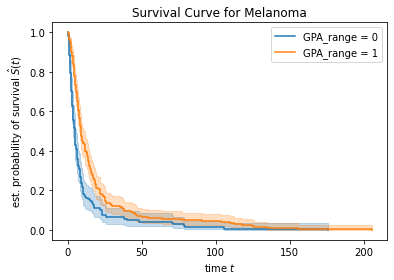

Primary tumor Site  gpa_range    median  median_lower_lim  \
0.5           Melanoma          0  4.622951          3.606557   
0.5           Melanoma          1  8.885246          7.639344   

     median_upper_lim  
0.5          5.409836  
0.5         11.475410

In [1034]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Melanoma', tolerance = 0)

In [1035]:
best_model_melanoma.append(best_model)

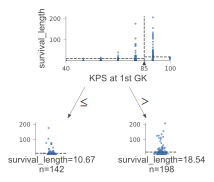

In [1036]:
tree_plot(best_model_melanoma[0],modelling_data, 'Melanoma')

In [1037]:
best_model_melanoma

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2,
                       min_samples_leaf=62)]

In [1038]:
rsquared

0.001657106579500356

### 3 leaves

In [1053]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 3 )

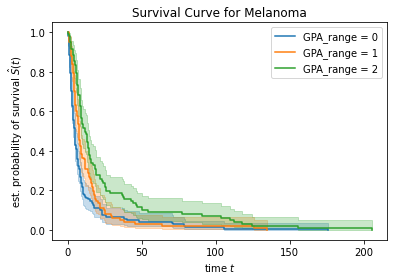

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5           Melanoma          0   4.622951          3.606557   
0.5           Melanoma          1   7.409836          6.000000   
0.5           Melanoma          2  11.475410          8.885246   

     median_upper_lim  
0.5          5.409836  
0.5          8.754098  
0.5         14.590164

In [1054]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Melanoma', tolerance = 1)

In [1055]:
best_model_melanoma.append(best_model)

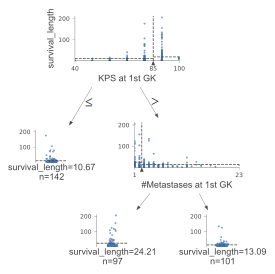

In [1056]:
tree_plot(best_model_melanoma[1],modelling_data, 'Melanoma')

In [1057]:
rsquared

-0.007186802283178695

### 4 Leaves

In [1107]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 4 )


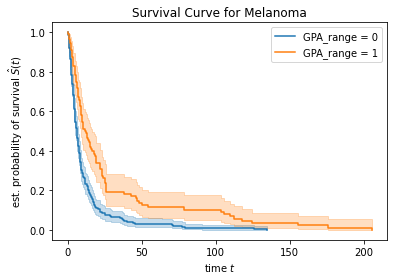

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5           Melanoma          0   6.131148          4.950820   
0.5           Melanoma          1  11.475410          8.885246   

     median_upper_lim  
0.5          7.180328  
0.5         16.131148

In [1108]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Melanoma', tolerance = 4)

In [1109]:
best_model_melanoma.append(best_model)

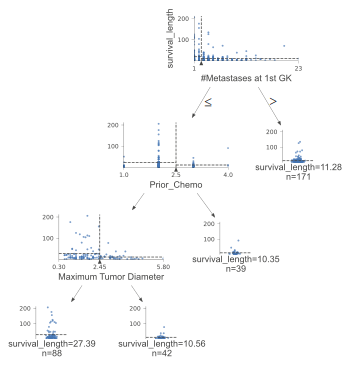

In [1110]:
tree_plot(best_model_melanoma[2],modelling_data, 'Melanoma')

In [1111]:
best_model_melanoma

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2,
                       min_samples_leaf=62),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=3,
                       min_samples_leaf=36),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4, min_samples_leaf=4)]

In [1112]:
rsquared

0.0032916804967897395

### 5 Leaves

In [1154]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 55, max_leaf_nodes = 5 )

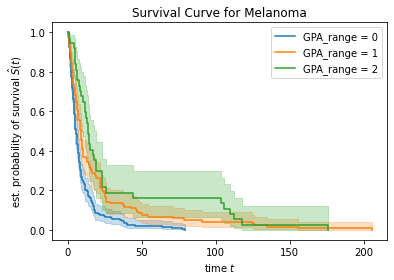

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5           Melanoma          0   5.409836          4.622951   
0.5           Melanoma          1   8.819672          6.885246   
0.5           Melanoma          2  13.868852         10.622951   

     median_upper_lim  
0.5          6.754098  
0.5          9.803279  
0.5         19.278689

In [1653]:
survival_curve_and_ci(best_model_melanoma[3],modelling_data, indication = 'Melanoma', tolerance = 0.5)

In [1156]:
best_model_melanoma.append(best_model)

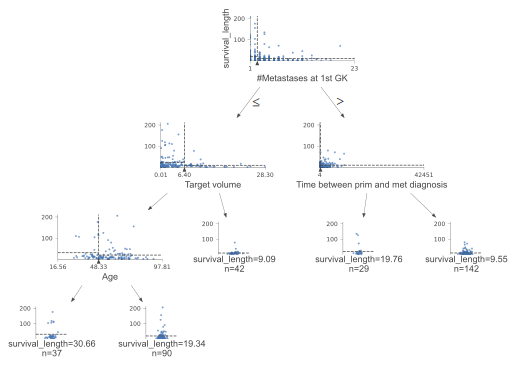

In [1157]:
tree_plot(best_model_melanoma[3],modelling_data, 'Melanoma')

In [1158]:
rsquared

-0.021528848682884183

### > 6 Leaves

In [1181]:
rsquared, best_model = pick_best_model(modelling_data, 'Melanoma', iterations = 25, max_leaf_nodes = 100 )

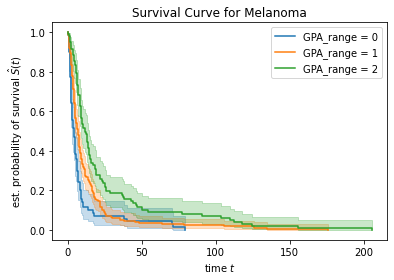

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5           Melanoma          0   4.131148          2.721311   
0.5           Melanoma          1   6.754098          5.180328   
0.5           Melanoma          2  11.475410          8.885246   

     median_upper_lim  
0.5          4.950820  
0.5          7.934426  
0.5         14.590164

In [1183]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Melanoma', tolerance = 1)

In [1184]:
best_model_melanoma.append(best_model)

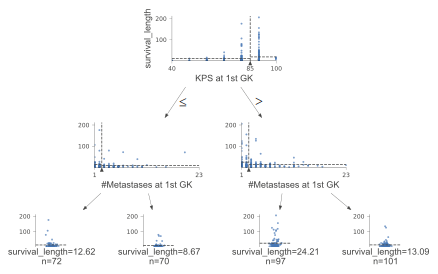

In [1185]:
tree_plot(best_model_melanoma[4],modelling_data, 'Melanoma')

In [1186]:
rsquared

-0.025140466723094335

In [1187]:
joblib.dump(best_model_melanoma[0], 'melanoma_2_leaf_node')
joblib.dump(best_model_melanoma[1], 'melanoma_3_leaf_node')
joblib.dump(best_model_melanoma[2], 'melanoma_4_leaf_node')
joblib.dump(best_model_melanoma[3], 'melanoma_5_leaf_node')
joblib.dump(best_model_melanoma[4], 'melanoma_6_leaf_node')

['melanoma_6_leaf_node']

In [1188]:
best_model_melanoma

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2,
                       min_samples_leaf=62),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=3,
                       min_samples_leaf=36),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4, min_samples_leaf=4),
 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=5,
                       min_samples_leaf=28),
 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=100,
                       min_samples_leaf=64)]

## LUNG

In [1189]:
best_model_lung = []

### 2 Leaves

In [1206]:
rsquared, best_model = pick_best_model(modelling_data, 'Lung', iterations = 55, max_leaf_nodes = 2 )


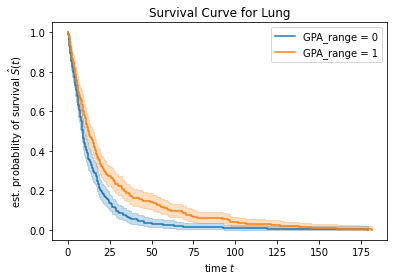

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5               Lung          0   8.885246          8.065574   
0.5               Lung          1  12.459016         10.819672   

     median_upper_lim  
0.5          9.901639  
0.5         15.114754

In [1207]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Lung')

In [1208]:
best_model_lung.append(best_model)

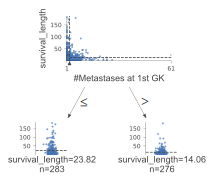

In [1209]:
tree_plot(best_model_lung[0],modelling_data, 'Lung')

### 3 Leaves

In [1242]:
rsquared, best_model = pick_best_model(modelling_data, 'Lung', iterations = 55, max_leaf_nodes = 3 )

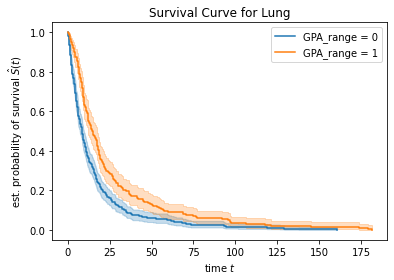

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5               Lung          0   8.590164          7.180328   
0.5               Lung          1  14.885246         12.000000   

     median_upper_lim  
0.5          9.573770  
0.5         17.639344

In [1247]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Lung', tolerance = 6)

In [1248]:
best_model_lung.append(best_model)

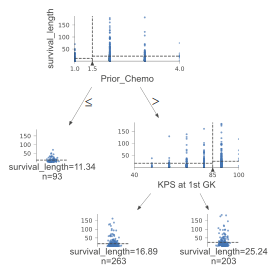

In [1249]:
tree_plot(best_model_lung[1],modelling_data, 'Lung')

In [1250]:
rsquared

0.027307083671204047

### 4 Leaves

In [1262]:
squared, best_model = pick_best_model(modelling_data, 'Lung', iterations = 25, max_leaf_nodes = 4 )

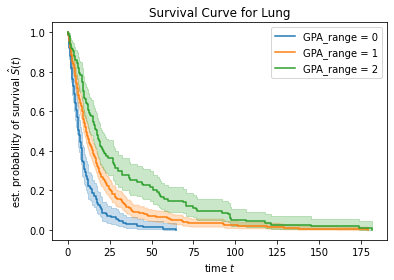

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5               Lung          0   6.524590          5.672131   
0.5               Lung          1  11.016393          9.508197   
0.5               Lung          2  17.278689         12.754098   

     median_upper_lim  
0.5          8.098361  
0.5         12.885246  
0.5         20.426230

In [1263]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Lung', tolerance = 3)

In [1264]:
best_model_lung.append(best_model)

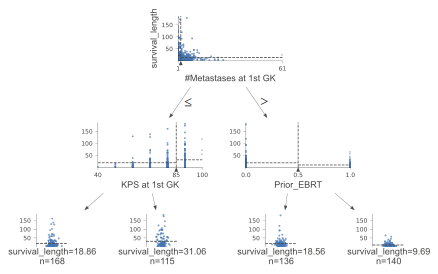

In [1265]:
tree_plot(best_model_lung[2],modelling_data, 'Lung')

In [1266]:
best_model_lung

[DecisionTreeRegressor(max_features='auto', max_leaf_nodes=2,
                       min_samples_leaf=77),
 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=3,
                       min_samples_leaf=14),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=4,
                       min_samples_leaf=47)]

### 5 Leaves

In [1337]:
squared, best_model = pick_best_model(modelling_data, 'Lung', iterations = 25, max_leaf_nodes = 5 )


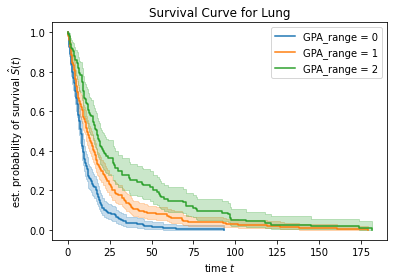

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5               Lung          0   8.000000          6.524590   
0.5               Lung          1  11.573770          9.803279   
0.5               Lung          2  17.278689         12.754098   

     median_upper_lim  
0.5          8.688525  
0.5         14.327869  
0.5         20.426230

In [1345]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Lung', tolerance = 4.4)

In [1346]:
best_model_lung.append(best_model)

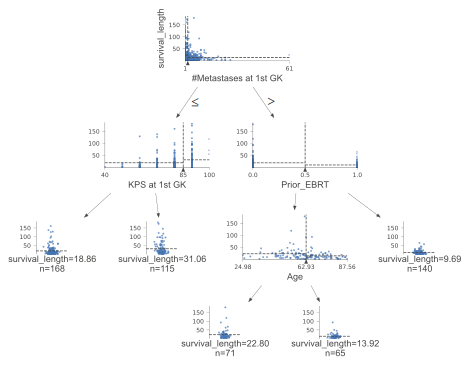

In [1347]:
tree_plot(best_model_lung[3],modelling_data, 'Lung')

### > 6 Leaves

In [1369]:
squared, best_model = pick_best_model(modelling_data, 'Lung', iterations = 25, max_leaf_nodes = 100 )

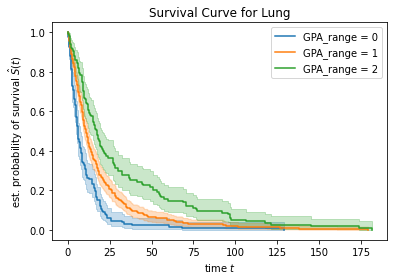

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5               Lung          0   6.000000          4.918033   
0.5               Lung          1  10.918033          9.311475   
0.5               Lung          2  17.278689         12.754098   

     median_upper_lim  
0.5          7.442623  
0.5         12.327869  
0.5         20.426230

In [1378]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Lung', tolerance = 4)

In [1379]:
best_model_lung.append(best_model)

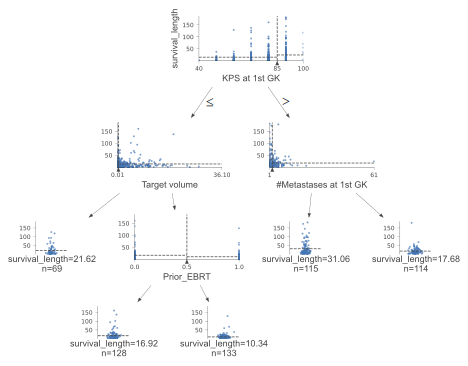

In [1380]:
tree_plot(best_model_lung[4],modelling_data, 'Lung')

In [1381]:
best_model_lung

[DecisionTreeRegressor(max_features='auto', max_leaf_nodes=2,
                       min_samples_leaf=77),
 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=3,
                       min_samples_leaf=14),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=4,
                       min_samples_leaf=47),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=5,
                       min_samples_leaf=53),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=69)]

In [1382]:
joblib.dump(best_model_lung[0], 'lung_2_leaf_node')
joblib.dump(best_model_lung[1], 'lung_3_leaf_node')
joblib.dump(best_model_lung[2], 'lung_4_leaf_node')
joblib.dump(best_model_lung[3], 'lung_5_leaf_node')
joblib.dump(best_model_lung[4], 'lung_6_leaf_node')

['lung_6_leaf_node']

## BREAST

In [1383]:
best_model_breast = []

### 2 Leaves

In [1398]:
rsquared, best_model = pick_best_model(modelling_data, 'Breast', iterations = 55, max_leaf_nodes = 2 )

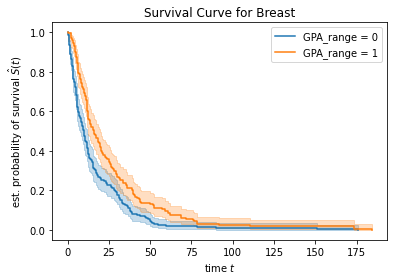

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Breast          0   9.639344          7.573770   
0.5             Breast          1  15.704918         12.393443   

     median_upper_lim  
0.5         11.672131  
0.5         19.672131

In [1399]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Breast')

In [1400]:
best_model_breast.append(best_model)

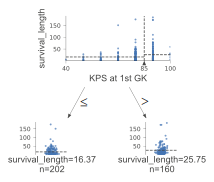

In [1401]:
tree_plot(best_model_breast[0],modelling_data, 'Breast')

### 3 Leaves

In [1416]:
rsquared, best_model = pick_best_model(modelling_data, 'Breast', iterations = 25, max_leaf_nodes = 3 )

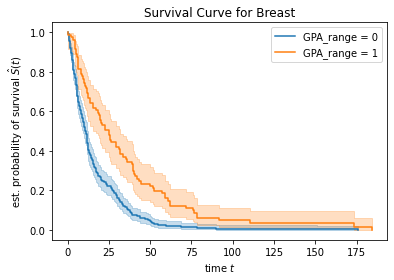

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Breast          0  10.721311          9.081967   
0.5             Breast          1  24.950820         17.114754   

     median_upper_lim  
0.5         12.000000  
0.5         31.639344

In [1425]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Breast', tolerance = 4.35)

In [1426]:
best_model_breast.append(best_model)

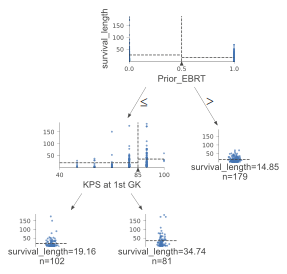

In [1427]:
tree_plot(best_model_breast[1],modelling_data, 'Breast')

### 4 Leaves

In [1453]:
rsquared, best_model = pick_best_model(modelling_data, 'Breast', iterations = 25, max_leaf_nodes = 4)


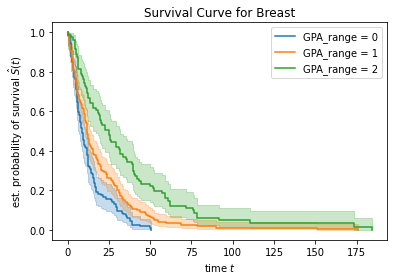

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Breast          0   8.950820          6.786885   
0.5             Breast          1  11.803279         10.229508   
0.5             Breast          2  24.950820         17.114754   

     median_upper_lim  
0.5         11.606557  
0.5         13.573770  
0.5         31.639344

In [1455]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Breast', tolerance = 1)

In [1456]:
best_model_breast.append(best_model)

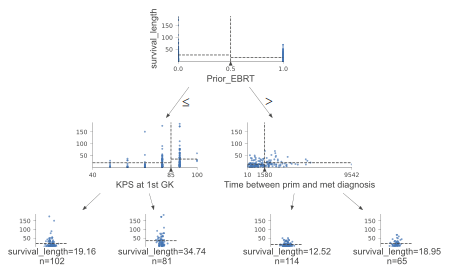

In [1457]:
tree_plot(best_model_breast[2],modelling_data, 'Breast')

In [1458]:
best_model_breast

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2, min_samples_leaf=5),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=3,
                       min_samples_leaf=70),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=4,
                       min_samples_leaf=64)]

### 5 Leaves

In [1552]:
rsquared, best_model = pick_best_model(modelling_data, 'Breast', iterations = 55, max_leaf_nodes = 5)


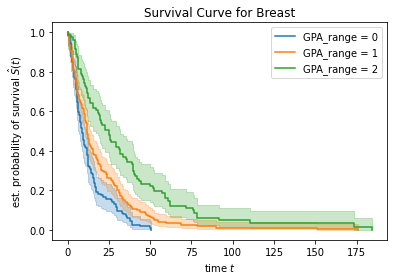

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Breast          0   8.950820          6.786885   
0.5             Breast          1  11.803279         10.229508   
0.5             Breast          2  24.950820         17.114754   

     median_upper_lim  
0.5         11.606557  
0.5         13.573770  
0.5         31.639344

In [1554]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Breast', tolerance = 1)

In [1555]:
best_model_breast.append(best_model)

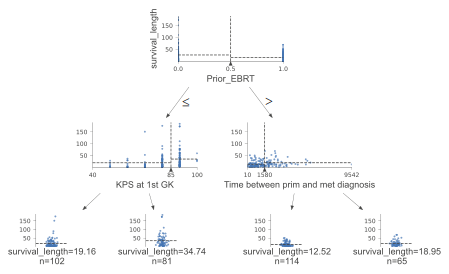

In [1556]:
tree_plot(best_model_breast[3],modelling_data, 'Breast')

### > 6 Leaves

In [1618]:
rsquared, best_model = pick_best_model(modelling_data, 'Breast', iterations = 25, max_leaf_nodes = 100)


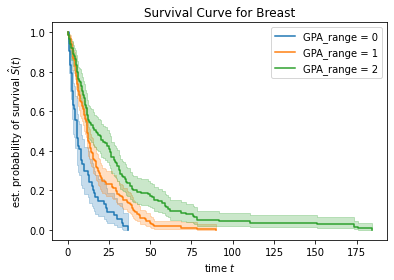

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Breast          0   5.836066          3.508197   
0.5             Breast          1  11.868852         10.196721   
0.5             Breast          2  17.344262         12.000000   

     median_upper_lim  
0.5          7.934426  
0.5         13.409836  
0.5         24.950820

In [1638]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Breast', tolerance = 4.75)

In [1627]:
best_model_breast.append(best_model)

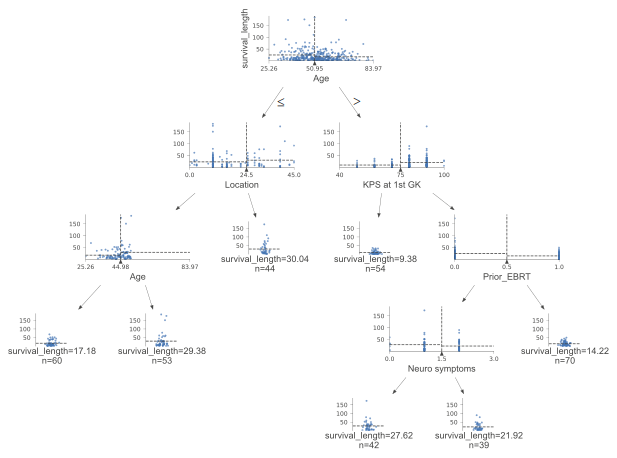

In [1628]:
tree_plot(best_model_breast[4],modelling_data, 'Breast')

In [1458]:
best_model_breast

[DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=2, min_samples_leaf=5),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=3,
                       min_samples_leaf=70),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=4,
                       min_samples_leaf=64)]

## Kidney

In [1666]:
best_model_kidney = []

### 2 Leaves

In [1662]:
rsquared, best_model = pick_best_model(modelling_data, 'Kidney', iterations = 50, max_leaf_nodes = 2 )

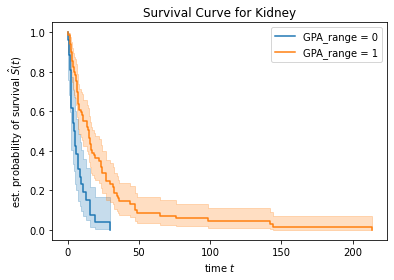

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Kidney          0   4.459016          2.393443   
0.5             Kidney          1  14.754098          7.770492   

     median_upper_lim  
0.5          7.508197  
0.5         18.721311

In [1663]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney')

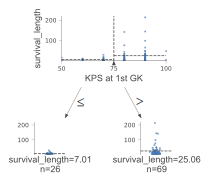

In [1664]:
tree_plot(best_model,modelling_data, 'Kidney')

In [1667]:
best_model_kidney.append(best_model)

In [1668]:
rsquared

-0.006462414644379244

### 3 Leaves

In [1697]:
rsquared, best_model = pick_best_model(modelling_data, 'Kidney', iterations = 25, max_leaf_nodes = 3)

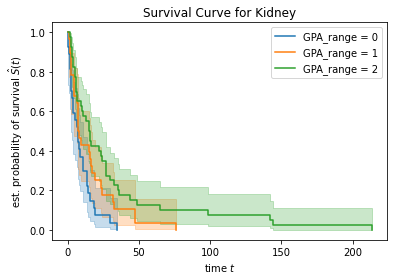

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Kidney          0   7.180328          2.688525   
0.5             Kidney          1   7.344262          4.491803   
0.5             Kidney          2  15.147541          6.688525   

     median_upper_lim  
0.5         11.081967  
0.5         16.229508  
0.5         23.967213

In [1698]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney')

In [1699]:
best_model_kidney.append(best_model)


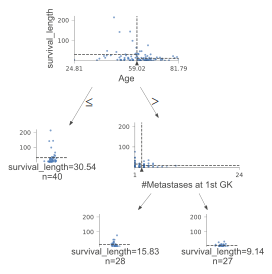

In [1862]:
tree_plot(best_model_kidney[1],modelling_data, 'Kidney')

In [1702]:
best_model_kidney.append(best_model)

### 4 Leaves

In [1875]:
rsquared, best_model = pick_best_model(modelling_data, 'Kidney', iterations = 150, max_leaf_nodes = 4)


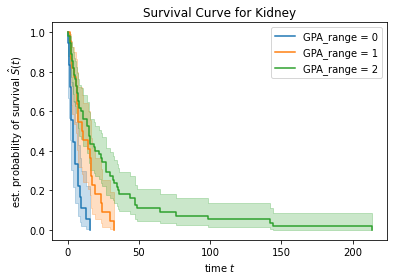

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Kidney          0   3.639344          1.573770   
0.5             Kidney          1   9.770492          5.540984   
0.5             Kidney          2  15.114754          7.770492   

     median_upper_lim  
0.5          7.213115  
0.5         16.721311  
0.5         23.213115

In [1892]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney', tolerance = 5)

In [1888]:
best_model_kidney.append(best_model)

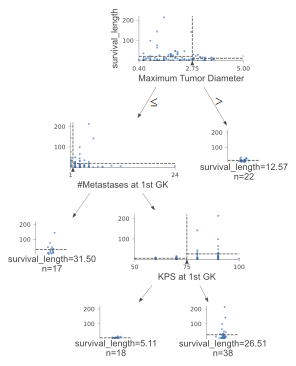

In [1889]:
tree_plot(best_model_kidney[2],modelling_data, 'Kidney')

In [1932]:
best_model_kidney

[DecisionTreeRegressor(max_features='log2', max_leaf_nodes=2,
                       min_samples_leaf=21),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=3,
                       min_samples_leaf=27),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4,
                       min_samples_leaf=10)]

### > 5 Leaves

In [1926]:
rsquared, best_model = pick_best_model(modelling_data, 'Kidney', iterations = 150, max_leaf_nodes = 100)


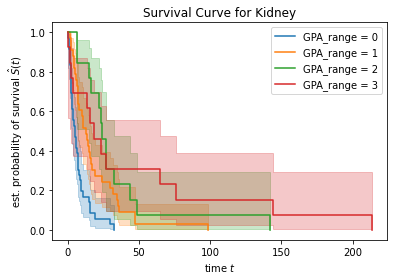

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Kidney          0   4.983607          3.049180   
0.5             Kidney          1  12.655738          7.180328   
0.5             Kidney          2  23.967213         14.754098   
0.5             Kidney          3  18.721311          2.491803   

     median_upper_lim  
0.5          7.213115  
0.5         16.229508  
0.5         32.196721  
0.5         64.983607

In [1931]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney', tolerance = 3)

In [1933]:
best_model_kidney.append(best_model)

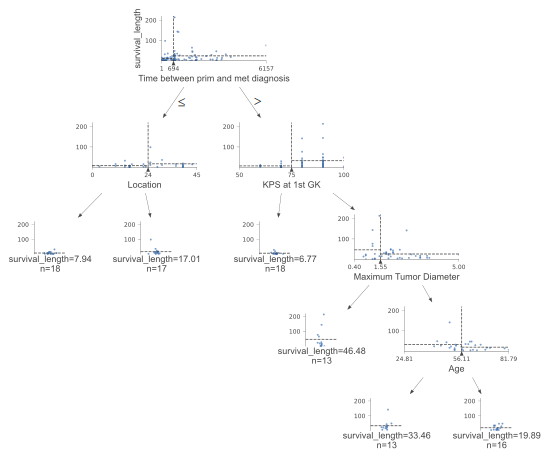

In [1934]:
tree_plot(best_model_kidney[3],modelling_data, 'Kidney')

In [1944]:
joblib.dump(best_model_kidney[0], 'kidney_2_leaf_node')
joblib.dump(best_model_kidney[1], 'kidney_2_leaf_node')
joblib.dump(best_model_kidney[2], 'kidney_2_leaf_node')
joblib.dump(best_model_kidney[3], 'kidney_2_leaf_node')

[DecisionTreeRegressor(max_features='log2', max_leaf_nodes=2,
                       min_samples_leaf=21),
 DecisionTreeRegressor(max_features='auto', max_leaf_nodes=3,
                       min_samples_leaf=27),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=4,
                       min_samples_leaf=10),
 DecisionTreeRegressor(max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=13)]

### Step 3

In [1616]:
from sklearn.ensemble import RandomForestRegressor
def get_random_hyper():
    min_samples_leaf = np.random.randint(low = 4, high = 80, size=1)[0]
    max_depth = np.random.randint(low = 1, high = 5, size=1)[0]
    max_features = sample(['sqrt','log2'],1)
    return min_samples_leaf,max_depth,max_features[0]

In [1648]:
y = modelling_dataset[modelling_dataset['Primary tumor Site'] == 'Melanoma']['Time to death']
x = modelling_dataset[modelling_dataset['Primary tumor Site'] == 'Melanoma'].drop(['Time to death','Primary tumor Site'],axis =1)
x.reset_index(inplace = True)
x.drop('index', inplace = True, axis =1)
y.reset_index(inplace = True, drop = True)
max_rsquared = -100
y_test_total = []
## iterating over the decision tree hyperparameters and picking the best
kf = KFold(n_splits = 10)
kf.get_n_splits(x)
y_pred = []
for i in range(0,100):
    min_samples_leaf, max_depth,max_features = get_random_hyper()
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        rf = RandomForestRegressor(max_depth = max_depth, 
                                   min_samples_leaf = min_samples_leaf, max_features = 'log2',
                                  n_estimators = 300)
        rf.fit(x_train, y_train)
        y_pred.append(dt.predict(x_test))
        y_test_total.append(y_test)
    r_squared = r2_score(np.concatenate(y_test_total), np.concatenate(y_pred))
    if r_squared > max_rsquared:
        max_rsquared = r_squared
        best_model = dt    
    
#dt.score(y_train.values.reshape(-1,1),y_pred.reshape(-1,1))

In [1642]:
prediction = best_model.predict(x)
prediction = pd.Series(prediction)
melanoma = pd.concat([y,prediction],axis = 1)
melanoma.rename(columns = {0: 'prediction'}, inplace = True)
a = list(melanoma['prediction'].unique())
a.sort()
melanoma['New_GPA'] = melanoma['prediction'].map(lambda x: a.index(x))
melanoma['Died'] = True
melanoma.drop('prediction', axis  = 1, inplace = True)
gpa_range = list(melanoma['New_GPA'].unique())
gpa_range.sort()

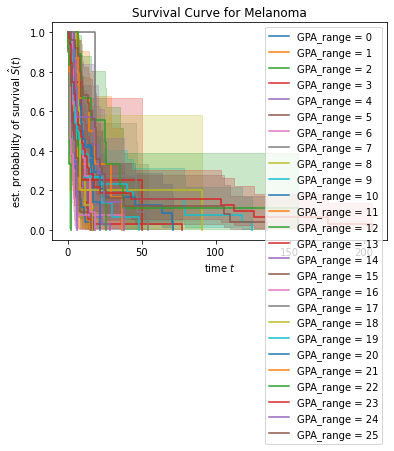

In [1639]:
survival_curve_kmf(melanoma, gpa_range, site_name = 'Melanoma', 
                   classes = "New_GPA", survival_col = "Died",time_col = "Time to death")

In [1647]:
prediction.value_counts()

21.809895    1
9.747496     1
10.350591    1
16.974556    1
16.013766    1
            ..
16.607534    1
16.498315    1
10.682225    1
20.011387    1
10.625013    1
Length: 345, dtype: int64

In [1649]:
max_rsquared

0.10772615246940476

### My tree

In [ ]:
def loss_func(g1,g2)
    from scipy.stats import median_test
    (tstat, p_value,median, tbl) = median_test(g1, g2)
    return p_value

In [1001]:
import numpy as np
from sklearn.metrics import r2_score,accuracy_score
from scipy.stats import mode
from scipy.stats import median_test

class DecisionNode:
    def __init__(self, col, split, lchild, rchild):
        self.col = col
        self.split = split
        self.lchild = lchild
        self.rchild = rchild

    def predict(self, x_test):
        # Make decision based upon x_test[col] and split
        if x_test[self.col] <= self.split:
            return self.lchild.predict(x_test)
        else:
            return self.rchild.predict(x_test)
    
    def node_print(self):
        print(self.col, self.split)
        ...

class LeafNode:
    def __init__(self, y, prediction):
        "Create leaf node from y values and prediction; prediction is mean(y) or mode(y)"
        self.n = len(y)
        self.prediction = prediction

    def predict(self, x_test):
        # return prediction
        return self.prediction
    
    def node_print(self):
        print(self.n, self.prediction)
    
class DecisionTree621:

    def __init__(self, min_samples_leaf=1, loss=None):
        self.min_samples_leaf = min_samples_leaf
        self.loss = loss # loss function; either np.std or gini


    def fit(self, X, y, p_value):
        """
        Create a decision tree fit to (X,y) and save as self.root, the root of
        our decision tree, for either a classifier or regressor.  Leaf nodes for classifiers
        predict the most common class (the mode) and regressors predict the average y
        for samples in that leaf.  
              
        This function is a wrapper around fit_() that just stores the tree in self.root.
        """
        self.root = self.fit_stat(X, y, p_value)
        
        
    def fit_stat(self, X, y, p_value):
        """
        Recursively create and return a decision tree fit to (X,y) for
        either a classifier or regressor.  This function should call self.create_leaf(X,y)
        to create the appropriate leaf node, which will invoke either
        RegressionTree621.create_leaf() or ClassifierTree621. create_leaf() depending
        on the type of self.

        This function is not part of the class "interface" and is for internal use, but it
        embodies the decision tree fitting algorithm.

        (Make sure to call fit_() not fit() recursively.)
        """
        def bestsplit(X, y, loss, p_value):
            best = (-1,-1)
            best_loss = p_value 
            for i in range(0,X.shape[1]):
                col = i 
                k = 11
                choices = np.random.choice(X.iloc[:,i],min(k,len(X)),replace = False)
                for j in choices:
                    yl = y[X.iloc[:,col]<=j].values
                    yr = y[X.iloc[:,col]>j].values
                    if (len(yl)< self.min_samples_leaf or len(yr) < self.min_samples_leaf):
                        continue
                    l = loss(yl, yr)
                    if l == 0:
                        best = (col,j)
                        return best
                    if l < best_loss:
                        best_loss = l
                        best = (col,j)
            return best[0],best[1]

        if len(X) < self.min_samples_leaf:
            return self.create_leaf(y)
        col,split = (bestsplit(X,y,self.loss,p_value))
        if col == -1:
            return self.create_leaf(y)
        lchild = self.fit_stat(X[X.iloc[:,col]<=split],y[X.iloc[:,col]<=split],p_value)
        rchild = self.fit_stat(X[X.iloc[:,col]>split],y[X.iloc[:,col]>split],p_value)
        return DecisionNode(col,split,lchild,rchild)
    
    def predict(self, X_test):
        """
        Make a prediction for each record in X_test and return as array.
        This method is inherited by RegressionTree621 and ClassifierTree621 and
        works for both without modification!
        """
        prediction = []
        for i in range(X_test.shape[0]):
            prediction.append(self.root.predict(X_test.iloc[i]))
        return prediction
    
    def tree_print(self, node, data ,level = 0):
        if isinstance(node,DecisionNode):
            self.tree_print(node.lchild, data ,level + 1)
            print(' ' * 4 * level + '->', (data.columns[node.col],"split point " + str(node.split)))
            self.tree_print(node.rchild, data ,level + 1)
        else:
            print(' ' * 4 * level + '->', (str(node.prediction) + " months",str(node.n) +" patients"))
            return
            

class RegressionTree621(DecisionTree621):
    def __init__(self, min_samples_leaf=1):

        super().__init__(min_samples_leaf, loss = median_p)


    def score(self, X_test, y_test):
        "Return the R^2 of y_test vs predictions for each record in X_test"
        y_pred = self.predict(X_test)
        return np.round(r2_score(y_pred,y_test),3)

        
    def create_leaf(self, y):
        """
        Return a new LeafNode for regression, passing y and mean(y) to
        the LeafNode constructor.
        """
        prediction = np.mean(y)
        return LeafNode(y, prediction)
    
def median_p(g1,g2):
    (tstat, p_value,median, tbl) = median_test(g1, g2) 
    return p_value       

## Kidney

In [982]:
# y = modelling_data[modelling_data['Primary tumor Site'] == 'Melanoma']['Time to death']
# x = modelling_data[modelling_data['Primary tumor Site'] == 'Melanoma'].drop(['Time to death','Primary tumor Site'],axis =1)
# x.reset_index(inplace = True)
# x.drop('index', inplace = True, axis = 1)
# y.reset_index(inplace = True, drop = True)
# max_rsquared = -100
# y_test_total = []
# ## iterating over the decision tree hyperparameters and picking the best
# kf = KFold(n_splits = 10)
# kf.get_n_splits(x)
# y_pred = []
# for train_index, test_index in kf.split(x):
#     x_train, x_test = x.iloc[train_index], x.iloc[test_index] 
#     y_train, y_test = y[train_index], y[test_index]
#     dt = RegressionTree621(min_samples_leaf = 35)
#     dt.fit(x_train, y_train)
#     y_pred.append(dt.predict(x_test))
#     y_test_total.append(y_test)
# r_squared = r2_score(np.concatenate(y_test_total), np.concatenate(y_pred))
# if r_squared > max_rsquared:
#     max_rsquared = r_squared
#     best_model = dt


In [978]:
np.array(np.unique(best_model.predict(x)))

array([10.95105899, 12.48848775, 25.63124397])

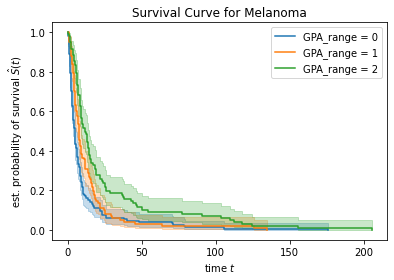

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5           Melanoma          0   4.622951          3.672131   
0.5           Melanoma          1   7.409836          6.000000   
0.5           Melanoma          2  11.475410          8.885246   

     median_upper_lim  
0.5          5.409836  
0.5          8.754098  
0.5         14.590164

In [979]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Melanoma')

In [1047]:
def pick_best_model_2(modelling_data,indication, p_value = 0.002, min_samples_leaf = 5):
    y = modelling_data[modelling_data['Primary tumor Site'] == indication]['Time to death']
    x = modelling_data[modelling_data['Primary tumor Site'] == indication].drop(['Time to death','Primary tumor Site'],axis =1)
    x.reset_index(inplace = True)
    x.drop('index', inplace = True, axis = 1)
    y.reset_index(inplace = True, drop = True)
    max_rsquared = -100
    y_test_total = []
    ## iterating over the decision tree hyperparameters and picking the best
    kf = KFold(n_splits = 10)
    kf.get_n_splits(x)
    y_pred = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        dt = RegressionTree621(min_samples_leaf = min_samples_leaf)
        dt.fit(x_train, y_train, p_value = p_value)
        y_pred.append(dt.predict(x_test))
        y_test_total.append(y_test)
    r_squared = r2_score(np.concatenate(y_test_total), np.concatenate(y_pred))
    if r_squared > max_rsquared:
        max_rsquared = r_squared
        best_model = dt
    return max_rsquared,best_model     

In [1029]:
rsquared,best_model =  pick_best_model_2(modelling_data,indication = 'Kidney', p_value = 0.015, min_samples_leaf = 10)

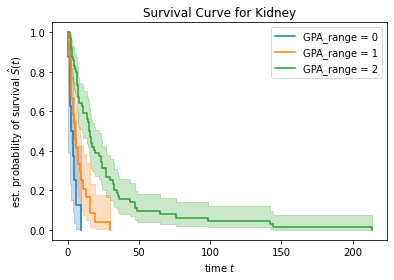

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Kidney          0   4.065574          0.098361   
0.5             Kidney          1   4.983607          2.557377   
0.5             Kidney          2  15.344262          9.770492   

     median_upper_lim  
0.5          5.704918  
0.5          8.852459  
0.5         21.770492

In [1030]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney')

In [1031]:
best_model.tree_print(best_model.root,x)

        -> ('7.7901639344262295 months', '20 patients')
    -> ('KPS at 1st GK', 'split point 70.0')
        -> ('26.973603778827453 months', '59 patients')
-> ('Prior_Chemo', 'split point 2')
    -> ('3.60655737704918 months', '8 patients')


In [1032]:
best_model_kidney.append(best_model)

### 2 Leaves

In [1050]:
rsquared,best_model = pick_best_model_2(modelling_data,indication = 'Kidney', p_value = 0.012, min_samples_leaf = 8)

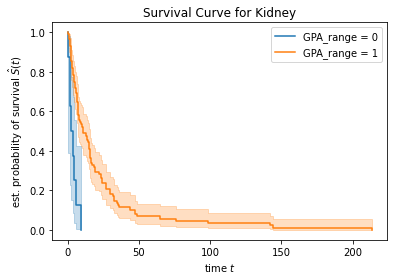

Primary tumor Site  gpa_range     median  median_lower_lim  \
0.5             Kidney          0   4.065574          0.098361   
0.5             Kidney          1  10.983607          7.213115   

     median_upper_lim  
0.5          5.704918  
0.5         15.344262

In [1051]:
survival_curve_and_ci(best_model,modelling_data, indication = 'Kidney')

In [1053]:
best_model.tree_print(best_model.root,x)

    -> ('22.11703672961195 months', '79 patients')
-> ('Prior_Chemo', 'split point 2')
    -> ('3.60655737704918 months', '8 patients')


In [1052]:
best_model_kidney.append(best_model)